##Apa itu GANs (Generative Adverserial Network)

> GANs adalah framework baru dimana  Dua model dilatih secara bersamaan oleh proses permusuhan. sebuah fungsi generator dianggap sebagai("seniman") belajar membuat gambar yang terlihat nyata, sementara sebuah fungsi diskriminator dianggap sebagai ("kritikus seni") belajar membedakan gambar asli dari yang palsu.
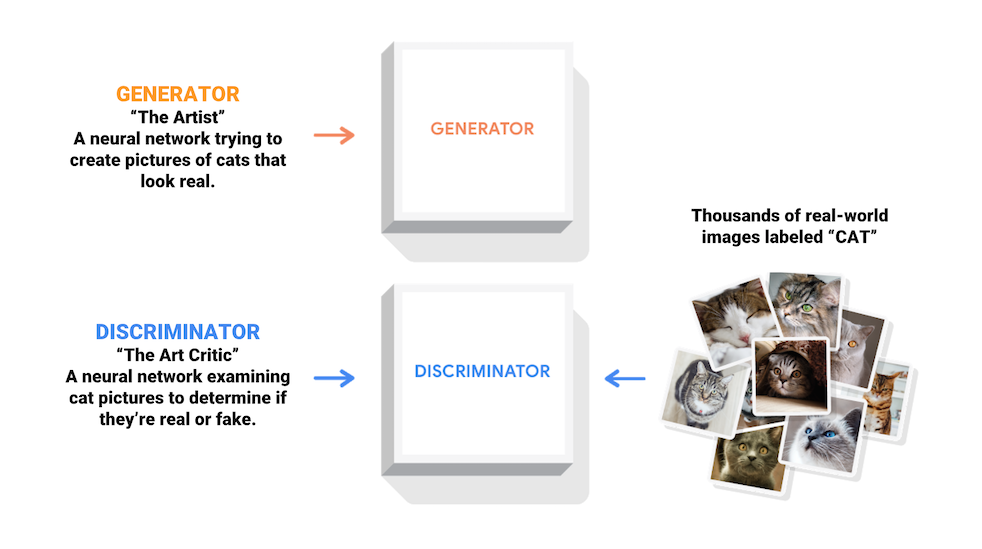
> Selama pelatihan, generator secara bertahap menjadi lebih baik dalam menciptakan gambar yang terlihat nyata, sementara diskriminator menjadi lebih baik dalam membedakannya. Proses mencapai keseimbangan ketika diskriminator tidak bisa lagi membedakan gambar asli dan palsu.
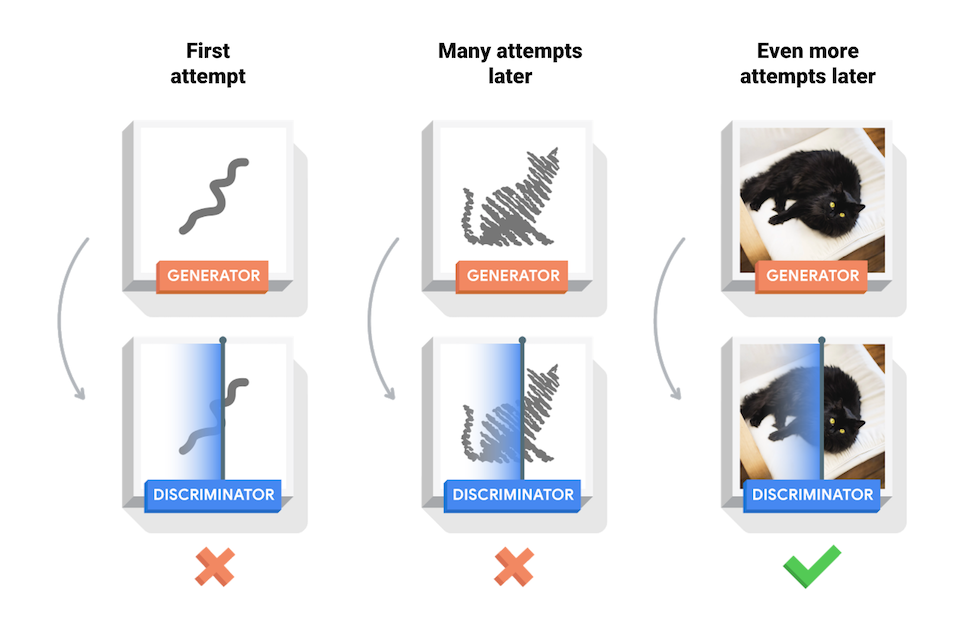


[*resource from TensorFlow*](https://www.tensorflow.org/tutorials/generative/dcgan)

##Import library tensorflow

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-s_9kjoyt
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-s_9kjoyt
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=88b10d0a0fb582134a6d9d0a1ed0667431b0b532c5333d50c030822bfaa63eb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-3rmi4n9l/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

##Load and prepare the dataset
> menggunakan dataset MNIST untuk melatih generator dan diskriminator. Generator akan menghasilkan angka tulisan tangan yang menyerupai data MNIST.



In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##Create the models

> generator maupun diskriminator ditentukan menggunakan Keras Sequential API.


> Generator menggunakan lapisan tf.keras.layers.Conv2DTranspose (upsampling) untuk menghasilkan gambar dari seed (noise acak). Mulai dengan Dense Layer yang mengambil seed sebagai input, lalu upsample beberapa kali mencapai ukuran gambar yang diinginkan 28x28x1. Perhatikan aktivasi tf.keras.layers.LeakyReLU untuk setiap layer, kecuali layer output yang menggunakan tanh.





In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

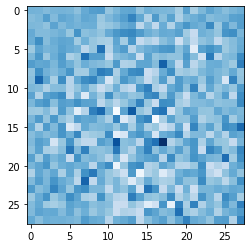

In [12]:
#Gunakan generator (belum terlatih) untuk membuat gambar.
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='Blues')

##Diskriminator

> Diskriminator adalah pengklasifikasi gambar berbasis CNN.



In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


> Gunakan diskriminator (belum terlatih) untuk mengklasifikasikan gambar yang dihasilkan sebagai nyata atau palsu. Model akan dilatih untuk menghasilkan nilai positif untuk gambar asli, dan nilai negatif untuk gambar palsu.



In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00114992]], shape=(1, 1), dtype=float32)


##Define the loss and optimizers
Tentukan fungsi loss dan optimizers untuk kedua model.

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

##Discriminator Loss

> Metode ini mengukur seberapa baik diskriminator mampu membedakan gambar asli dari palsu. Ini membandingkan prediksi diskriminator pada gambar nyata ke array 1s, dan prediksi diskriminator pada gambar palsu (dihasilkan) ke array 0s.



In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

##Generator Loss


> Kerugian generator mengkuantifikasi seberapa baik ia mampu mengelabui diskriminator. Secara intuitif, jika generator berkinerja baik, diskriminator akan mengklasifikasikan gambar palsu sebagai nyata (atau 1). Di sini, bandingkan keputusan diskriminator pada gambar yang dihasilkan dengan array 1s.




In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



> Diskriminator dan pengoptimal generator berbeda karena akan melatih dua jaringan secara terpisah.



In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##Save checkpoints

> Notebook ini juga menunjukkan cara menyimpan dan memulihkan model, yang dapat membantu jika tugas pelatihan yang berjalan lama terganggu.



In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
#Define the training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

> Loop pelatihan dimulai dengan generator menerima benih acak sebagai input. Benih itu digunakan untuk menghasilkan gambar. Diskriminator kemudian digunakan untuk mengklasifikasikan gambar asli (diambil dari set pelatihan) dan gambar palsu (diproduksi oleh generator). Kerugian dihitung untuk masing-masing model ini, dan gradien digunakan untuk memperbarui generator dan diskriminator.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

##Generate and save images

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

##Train the models
> Panggil metode train() yang didefinisikan di atas untuk melatih generator dan diskriminator secara bersamaan. Catatan, melatih GAN bisa jadi rumit. Penting agar generator dan diskriminator tidak saling mengalahkan (misalnya, mereka berlatih dengan kecepatan yang sama).

> Pada awal pelatihan, gambar yang dihasilkan terlihat seperti noise acak. Saat pelatihan berlangsung, angka yang dihasilkan akan terlihat semakin nyata. Setelah sekitar 50 epochs, mereka menyerupai angka MNIST. Ini mungkin memakan waktu sekitar satu menit / waktu dengan pengaturan default di Colab.

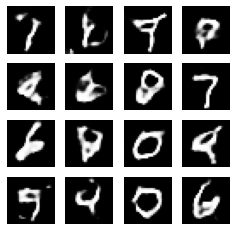

In [24]:
train(train_dataset, EPOCHS)

> Gunakan fungsi imageio untuk membuat gif animasi menggunakan gambar yang disimpan selama pelatihan



In [25]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


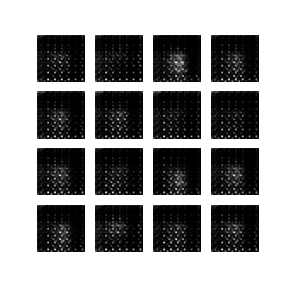

In [26]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)